In [1]:
import neurom as nm

import pandas as pd
import networkx as nx
import numpy as np

# To delete when installation works
import sys
sys.path.append("../")

from morphopy.neurontree import NeuronTree as nt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "./persistence_test/data/C010398B-P2.CNG.swc"

swc = pd.read_csv(data_path,delim_whitespace=True, comment='#',
                  names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)

In [3]:
nm_neuron = nm.load_neuron(data_path)

/usr/local/lib/python3.5/dist-packages/neurom/core/_soma.py:237: UserWarning: Using neuromorpho 3-Point soma
  warnings.warn('Using neuromorpho 3-Point soma')
/usr/local/lib/python3.5/dist-packages/neurom/core/_soma.py:168: UserWarning: The second point must be one radius below 0 on the y-plane for SomaNeuromorphoThreePointCylinders(array([[27.48 , 22.09 ,  2.37 ,  6.474,  1.   ,  1.   , -1.   ],
       [27.48 , 28.56 ,  2.37 ,  6.474,  1.   ,  2.   ,  1.   ],
       [27.48 , 15.61 ,  2.37 ,  6.474,  1.   ,  3.   ,  1.   ]])) <center: [27.48 22.09  2.37], radius: 7.928590038588197>
  'The second point must be one radius below 0 on the y-plane for {}'.format(self))
/usr/local/lib/python3.5/dist-packages/neurom/core/_soma.py:171: UserWarning: The third point must be one radius above 0 on the y-plane for SomaNeuromorphoThreePointCylinders(array([[27.48 , 22.09 ,  2.37 ,  6.474,  1.   ,  1.   , -1.   ],
       [27.48 , 28.56 ,  2.37 ,  6.474,  1.   ,  2.   ,  1.   ],
       [27.48 , 15.61 

In [4]:
nt_neuron = nt.NeuronTree(swc)

In [5]:
z_nm = dict()
z_nm['branch points'] = nm.get('number_of_bifurcations', nm_neuron)[0]


z_nm['tips'] = nm.get('number_of_terminations',nm_neuron)[0]
z_nm['stems'] = nm.get('number_of_neurites',nm_neuron)[0]
z_nm['total length'] = nm.get('total_length',nm_neuron)[0]
z_nm['avg thickness'] = np.mean(nm.get('segment_radii', nm_neuron))

z_nm['total surface'] = np.sum(nm.get('total_area_per_neurite',nm_neuron))

z_nm['max branch order'] = np.max(nm.get('section_branch_orders', nm_neuron))

z_nm['max log tortuosity'] = np.log(np.percentile(nm.get('section_tortuosity', nm_neuron),99.5))
z_nm['min branch angle'] = np.min(nm.get('local_bifurcation_angles', nm_neuron))/np.pi*180
z_nm['max branch angle'] = np.max(nm.get('local_bifurcation_angles', nm_neuron))/np.pi*180
z_nm['mean branch angle'] = np.mean(nm.get('local_bifurcation_angles', nm_neuron))/np.pi*180


In [6]:
neurites = nt_neuron.get_neurites(soma_included=False)

In [7]:
x = {'branch points':0, 'tips':0, 'total length':0, 'max branch order':0, 
    'min branch angle': 180, 'max branch angle': 0}

for n in neurites:
    x['branch points'] += n.get_branchpoints().size
    x['tips'] += n.get_tips().size
    x['total length'] += np.sum(list(n.get_edge_attributes('path_length').values()))
    x['max branch order'] = np.max((x['max branch order'], np.max(list(n.get_branch_order().values()))))
    
branch_angles = list(nt_neuron.get_branch_angles().values())

x['min branch angle'] = np.min(branch_angles)
x['max branch angle'] = np.max(branch_angles)    
x['mean branch angle'] = np.mean(branch_angles)
x['stems'] = len(neurites)

radii = nt_neuron.get_node_attributes('radius')
# delete the soma
radii.pop(nt_neuron.get_root())
x['avg thickness'] = np.mean(list(radii.values()))

x['total surface'] = np.sum([s[1] for s in nt_neuron.get_surface().items() if s[0][0] != 1])

R = nt_neuron.get_topological_minor()
tortuosity = np.array([e[2]['path_length'] / e[2]['euclidean_dist'] for e in R.edges(data=True) if e[1] != R.get_root()])
x['max log tortuosity'] = np.log(np.percentile(tortuosity,99.5))

path_angles = list(nt_neuron.get_path_angles().values())

(array([  2.,   2.,   5.,  14.,  29.,  86., 187., 339., 385., 209.]),
 array([  2.27029858,  20.04222912,  37.81415966,  55.58609021,
         73.35802075,  91.12995129, 108.90188183, 126.67381238,
        144.44574292, 162.21767346, 179.98960401]),
 <a list of 10 Patch objects>)

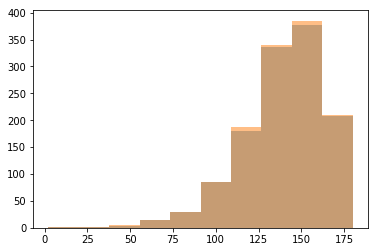

In [8]:
plt.hist(180-np.array(path_angles), alpha=.5)
plt.hist(nm.get('segment_meander_angles', nm_neuron)/np.pi*180, alpha=.5)

In [9]:
T = nt_neuron
z = dict()

z['branch points'] = T.get_branchpoints().size

tips = T.get_tips()

z['tips'] = tips.size

z['stems'] = len(T.edges(1))

z['total length'] = np.sum(list(T.get_edge_attributes('path_length').values()))
# get all radii
radii = T.get_node_attributes('radius')
# delete the soma
radii.pop(T.get_root())
z['avg thickness'] = np.mean(list(radii.values()))

z['total surface'] = np.sum(list(T.get_surface().values()))

z['max branch order'] = np.max(list(T.get_branch_order().values()))

branch_angles = list(T.get_branch_angles().values())
z['max branch angle'] = np.max(branch_angles)
z['min branch angle'] = np.min(branch_angles)
z['mean branch angle'] = np.mean(branch_angles)


tortuosity = [e[2]['path_length'] / e[2]['euclidean_dist'] for e in R.edges(data=True)]

z['max log tortuosity'] = np.log(np.percentile(tortuosity,99.5))




In [10]:
df = pd.DataFrame(z, index=['NeuronTree']).append(pd.DataFrame(x, index=['NeuronTree \n (no soma)']).append(pd.DataFrame(z_nm, index=['NeuroM'])))

In [11]:
df.T

,NeuronTree,NeuronTree (no soma),NeuroM
avg thickness,0.212922,0.212922,0.204238
branch points,35.000000,34.000000,34.000000
max branch angle,137.290397,137.290397,137.290397
max branch order,9.000000,8.000000,8.000000
max log tortuosity,0.438295,0.438295,0.438579
mean branch angle,73.760638,73.760638,73.760638
min branch angle,8.634836,8.634836,8.634836
stems,11.000000,11.000000,9.000000
tips,45.000000,45.000000,43.000000
total length,7123.449510,7036.522849,7036.522849


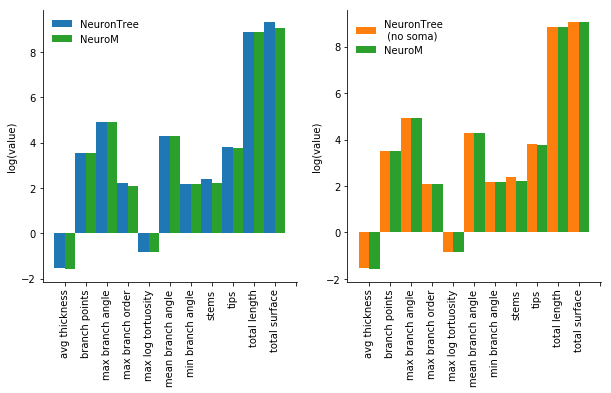

In [12]:
xses = np.vstack((np.arange(0.5,11.5,1),np.arange(1,12,1)))
colors = sns.color_palette()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.bar(xses[0,:],np.log(df.iloc[0].values), label= df.iloc[0].name, color=colors[0], width=.5)
plt.bar(xses[1,:],np.log(df.iloc[2].values), label= df.iloc[2].name, color=colors[2], width=.5)
sns.despine()
plt.ylabel('log(value)')

plt.gca().set_xticks(np.arange(.75,12,1))
_ = plt.gca().set_xticklabels(df.columns, rotation=90)
plt.legend(frameon=False, loc=2)

plt.subplot(122)
plt.bar(xses[0,:],np.log(df.iloc[1].values), label= df.iloc[1].name, color=colors[1], width=.5)
plt.bar(xses[1,:],np.log(df.iloc[2].values), label= df.iloc[2].name, color=colors[2], width=.5)
sns.despine()
plt.ylabel('log(value)')

plt.gca().set_xticks(np.arange(.75,12,1))
_ = plt.gca().set_xticklabels(df.columns, rotation=90)

plt.legend(frameon=False, loc=2)